<a href="https://colab.research.google.com/github/shumshersubashgautam/Computer-Aided-Drug-Discovery-Learning/blob/main/35_Graph_Neural_Network_based_molecular_property_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/volkamerlab/teachopencadd.git

Cloning into 'teachopencadd'...
remote: Enumerating objects: 17115, done.
remote: Counting objects: 100% (2094/2094), done.
remote: Compressing objects: 100% (971/971), done.
remote: Total 17115 (delta 1311), reused 1784 (delta 1121), pack-reused 15021
Receiving objects: 100% (17115/17115), 849.73 MiB | 32.24 MiB/s, done.
Resolving deltas: 100% (11503/11503), done.
Updating files: 100% (468/468), done.


# **Contents in Theory**
GNN Tasks

Message Passing

Graph Convolutional Network (GCN)

Graph Isomorphism Network (GIN)

Training a GNN

Applications of GNNs

Contents in Practical

Dataset

Defining a GCN and GIN

Training a GNN

Evaluating the model

In [3]:
!pip install rdkit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.7/29.7 MB 50.0 MB/s eta 0:00:00


**I have used PyTorch and PyTorch-Geometric, which helps us to handle graph data efficiently. PyTorch Geometric for example uses sparse matrix representations and implemented efficient graph batching.**

In [78]:
import math
import numpy
import pandas as pd
import matplotlib.pylab as plt
from matplotlib.ticker import MaxNLocator
from pathlib import Path

import torch
import torch.nn.functional as Fun
from torch.nn import Linear, Sequential, BatchNorm1d, ReLU

In [81]:
# #################################################################################
# # INSTALL MAMBA ON GOOGLE COLAB
# #################################################################################
# ! wget -O miniconda.sh https://repo.anaconda.com/miniconda/Miniconda3-py37_4.10.3-Linux-x86_64.sh
# ! chmod +x miniconda.sh
# ! bash ./miniconda.sh -b -f -p /usr/local
# ! rm miniconda.sh
# ! conda config --add channels conda-forge
# ! conda install -y mamba
# ! mamba update -qy --all
# ! mamba clean -qafy
# import sys
# sys.path.append('/usr/local/lib/python3.7/site-packages/')

In [82]:
import sys
if sys.platform.startswith(("linux", "darwin")):
    !mamba install -q -y -c pyg pyg


                  __    __    __    __
                 /  \  /  \  /  \  /  \
                /    \/    \/    \/    \
███████████████/  /██/  /██/  /██/  /████████████████████████
              /  / \   / \   / \   / \  \____
             /  /   \_/   \_/   \_/   \    o \__,
            / _/                       \_____/  `
            |/
        ███╗   ███╗ █████╗ ███╗   ███╗██████╗  █████╗
        ████╗ ████║██╔══██╗████╗ ████║██╔══██╗██╔══██╗
        ██╔████╔██║███████║██╔████╔██║██████╔╝███████║
        ██║╚██╔╝██║██╔══██║██║╚██╔╝██║██╔══██╗██╔══██║
        ██║ ╚═╝ ██║██║  ██║██║ ╚═╝ ██║██████╔╝██║  ██║
        ╚═╝     ╚═╝╚═╝  ╚═╝╚═╝     ╚═╝╚═════╝ ╚═╝  ╚═╝

        mamba (0.27.0) supported by @QuantStack

        GitHub:  https://github.com/mamba-org/mamba
        Twitter: https://twitter.com/QuantStack

█████████████████████████████████████████████████████████████

  Package                Version  Build                    Channel                   Size
───────────────────────

In [83]:
from torch_geometric.datasets import QM9
from torch_geometric.nn import GCNConv, GINConv
from torch_geometric.loader import DataLoader
from torch_geometric.nn import global_mean_pool, global_add_pool

In [84]:
# specify the local data path
HERE = Path(_dh[-1])
DATA = HERE / "data"

In [85]:
# load dataset
qm9 = QM9(root=DATA)
qm9[0]

Extracting /content/data/raw/qm9.zip
Processing...
100%|██████████| 133885/133885 [03:36<00:00, 617.15it/s]
Done!


Data(x=[5, 11], edge_index=[2, 8], edge_attr=[8, 4], y=[1, 19], pos=[5, 3], z=[5], name='gdb_1', idx=[1])

In [86]:
# get one regression target
y_target = pd.DataFrame(qm9.data.y.numpy())
qm9.data.y = torch.Tensor(y_target[0])

qm9 = qm9.shuffle()

# data split
data_size = 30000
train_index = int(data_size * 0.8)
test_index = train_index + int(data_size * 0.1)
val_index = test_index + int(data_size * 0.1)


# normalizing the data
data_mean = qm9.data.y[0:train_index].mean()
data_std = qm9.data.y[0:train_index].std()

qm9.data.y = (qm9.data.y - data_mean) / data_std

# datasets into DataLoader
train_loader = DataLoader(qm9[0:train_index], batch_size=64, shuffle=True)
test_loader = DataLoader(qm9[train_index:test_index], batch_size=64, shuffle=True)
val_loader = DataLoader(qm9[test_index:val_index], batch_size=64, shuffle=True)

In [87]:
class GCN(torch.nn.Module):
    """Graph Convolutional Network class with 3 convolutional layers and a linear layer"""

    def __init__(self, dim_h):
        """init method for GCN

        Args:
            dim_h (int): the dimension of hidden layers
        """
        super().__init__()
        self.conv1 = GCNConv(qm9.num_features, dim_h)
        self.conv2 = GCNConv(dim_h, dim_h)
        self.conv3 = GCNConv(dim_h, dim_h)
        self.lin = torch.nn.Linear(dim_h, 1)

    def forward(self, data):
        e = data.edge_index
        x = data.x

        x = self.conv1(x, e)
        x = x.relu()
        x = self.conv2(x, e)
        x = x.relu()
        x = self.conv3(x, e)
        x = global_mean_pool(x, data.batch)

        x = Fun.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)

        return x

In [88]:
class GIN(torch.nn.Module):
    """Graph Isomorphism Network class with 3 GINConv layers and 2 linear layers"""

    def __init__(self, dim_h):
        """Initializing GIN class

        Args:
            dim_h (int): the dimension of hidden layers
        """
        super(GIN, self).__init__()
        self.conv1 = GINConv(
            Sequential(Linear(11, dim_h), BatchNorm1d(dim_h), ReLU(), Linear(dim_h, dim_h), ReLU())
        )
        self.conv2 = GINConv(
            Sequential(
                Linear(dim_h, dim_h), BatchNorm1d(dim_h), ReLU(), Linear(dim_h, dim_h), ReLU()
            )
        )
        self.conv3 = GINConv(
            Sequential(
                Linear(dim_h, dim_h), BatchNorm1d(dim_h), ReLU(), Linear(dim_h, dim_h), ReLU()
            )
        )
        self.lin1 = Linear(dim_h, dim_h)
        self.lin2 = Linear(dim_h, 1)

    def forward(self, data):
        x = data.x
        edge_index = data.edge_index
        batch = data.batch

        # Node embeddings
        h = self.conv1(x, edge_index)
        h = h.relu()
        h = self.conv2(h, edge_index)
        h = h.relu()
        h = self.conv3(h, edge_index)

        # Graph-level readout
        h = global_add_pool(h, batch)

        h = self.lin1(h)
        h = h.relu()
        h = Fun.dropout(h, p=0.5, training=self.training)
        h = self.lin2(h)

        return h

# **Training a GNN**

In [89]:
def training(loader, model, loss, optimizer):
    """Training one epoch

    Args:
        loader (DataLoader): loader (DataLoader): training data divided into batches
        model (nn.Module): GNN model to train on
        loss (nn.functional): loss function to use during training
        optimizer (torch.optim): optimizer during training

    Returns:
        float: training loss
    """
    model.train()

    current_loss = 0
    for d in loader:
        optimizer.zero_grad()
        d.x = d.x.float()

        out = model(d)

        l = loss(out, torch.reshape(d.y, (len(d.y), 1)))
        current_loss += l / len(loader)
        l.backward()
        optimizer.step()
    return current_loss, model

In [90]:
def validation(loader, model, loss):
    """Validation

    Args:
        loader (DataLoader): validation set in batches
        model (nn.Module): current trained model
        loss (nn.functional): loss function

    Returns:
        float: validation loss
    """
    model.eval()
    val_loss = 0
    for d in loader:
        out = model(d)
        l = loss(out, torch.reshape(d.y, (len(d.y), 1)))
        val_loss += l / len(loader)
    return val_loss

In [91]:
@torch.no_grad()
def testing(loader, model):
    """Testing

    Args:
        loader (DataLoader): test dataset
        model (nn.Module): trained model

    Returns:
        float: test loss
    """
    loss = torch.nn.MSELoss()
    test_loss = 0
    test_target = numpy.empty((0))
    test_y_target = numpy.empty((0))
    for d in loader:
        out = model(d)
        # NOTE
        # out = out.view(d.y.size())
        l = loss(out, torch.reshape(d.y, (len(d.y), 1)))
        test_loss += l / len(loader)

        # save prediction vs ground truth values for plotting
        test_target = numpy.concatenate((test_target, out.detach().numpy()[:, 0]))
        test_y_target = numpy.concatenate((test_y_target, d.y.detach().numpy()))

    return test_loss, test_target, test_y_target

In [92]:
def train_epochs(epochs, model, train_loader, val_loader, path):
    """Training over all epochs

    Args:
        epochs (int): number of epochs to train for
        model (nn.Module): the current model
        train_loader (DataLoader): training data in batches
        val_loader (DataLoader): validation data in batches
        path (string): path to save the best model

    Returns:
        array: returning train and validation losses over all epochs, prediction and ground truth values for training data in the last epoch
    """
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
    loss = torch.nn.MSELoss()

    train_target = numpy.empty((0))
    train_y_target = numpy.empty((0))
    train_loss = numpy.empty(epochs)
    val_loss = numpy.empty(epochs)
    best_loss = math.inf

    for epoch in range(epochs):
        epoch_loss, model = training(train_loader, model, loss, optimizer)
        v_loss = validation(val_loader, model, loss)
        if v_loss < best_loss:
            torch.save(model.state_dict(), path)
        for d in train_loader:
            out = model(d)
            if epoch == epochs - 1:
                # record truly vs predicted values for training data from last epoch
                train_target = numpy.concatenate((train_target, out.detach().numpy()[:, 0]))
                train_y_target = numpy.concatenate((train_y_target, d.y.detach().numpy()))

        train_loss[epoch] = epoch_loss.detach().numpy()
        val_loss[epoch] = v_loss.detach().numpy()

        # print current train and val loss
        if epoch % 2 == 0:
            print(
                "Epoch: "
                + str(epoch)
                + ", Train loss: "
                + str(epoch_loss.item())
                + ", Val loss: "
                + str(v_loss.item())
            )
    return train_loss, val_loss, train_target, train_y_target

In [93]:
# training GCN for 10 epochs
epochs = 10

model = GCN(dim_h=128)

# Remember to change the path if you want to keep the previously trained model
gcn_train_loss, gcn_val_loss, gcn_train_target, gcn_train_y_target = train_epochs(
    epochs, model, train_loader, test_loader, "GCN_model.pt"
)

Epoch: 0, Train loss: 0.922526478767395, Val loss: 0.8226867914199829
Epoch: 2, Train loss: 0.8413522839546204, Val loss: 0.7781321406364441
Epoch: 4, Train loss: 0.8109099864959717, Val loss: 0.7518129348754883
Epoch: 6, Train loss: 0.7755736112594604, Val loss: 0.7758800983428955
Epoch: 8, Train loss: 0.7420257329940796, Val loss: 0.7053119540214539


In [94]:
# Training GIN for 10 epochs
model = GIN(dim_h=64)

# Remember to change the path if you want to keep the previously trained model
gin_train_loss, gin_val_loss, gin_train_target, gin_train_y_target = train_epochs(
    epochs, model, train_loader, test_loader, "GIN_model.pt"
)

Epoch: 0, Train loss: 0.6910080313682556, Val loss: 0.5682753324508667
Epoch: 2, Train loss: 0.5206065773963928, Val loss: 0.46398404240608215
Epoch: 4, Train loss: 0.46820855140686035, Val loss: 0.4513978660106659
Epoch: 6, Train loss: 0.44783681631088257, Val loss: 0.39953547716140747
Epoch: 8, Train loss: 0.4235866069793701, Val loss: 0.4042774438858032


In [95]:
def plot_loss(gcn_train_loss, gcn_val_loss, gin_train_loss, gin_val_loss):
    """Plot the loss for each epoch

    Args:
        epochs (int): number of epochs
        train_loss (array): training losses for each epoch
        val_loss (array): validation losses for each epoch
    """
    plt.plot(gcn_train_loss, label="Train loss (GCN)")
    plt.plot(gcn_val_loss, label="Val loss (GCN)")
    plt.plot(gin_train_loss, label="Train loss (GIN)")
    plt.plot(gin_val_loss, label="Val loss (GIN)")
    plt.legend()
    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.title("Model Loss")
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.show()

In [96]:
def plot_targets(pred, ground_truth):
    """Plot true vs predicted value in a scatter plot

    Args:
        pred (array): predicted values
        ground_truth (array): ground truth values
    """
    f, ax = plt.subplots(figsize=(6, 6))
    ax.scatter(pred, ground_truth, s=0.5)
    plt.xlim(-2, 7)
    plt.ylim(-2, 7)
    ax.axline((1, 1), slope=1)
    plt.xlabel("Predicted Value")
    plt.ylabel("Ground truth")
    plt.title("Ground truth vs prediction")
    plt.show()

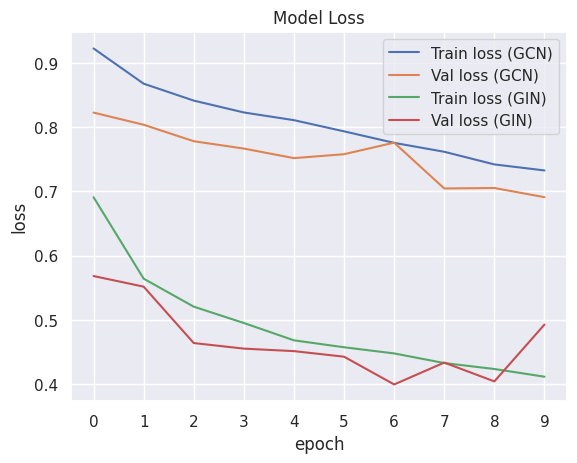

In [97]:
# Plot overall losses of GIN and GCN

plot_loss(gcn_train_loss, gcn_val_loss, gin_train_loss, gin_val_loss)

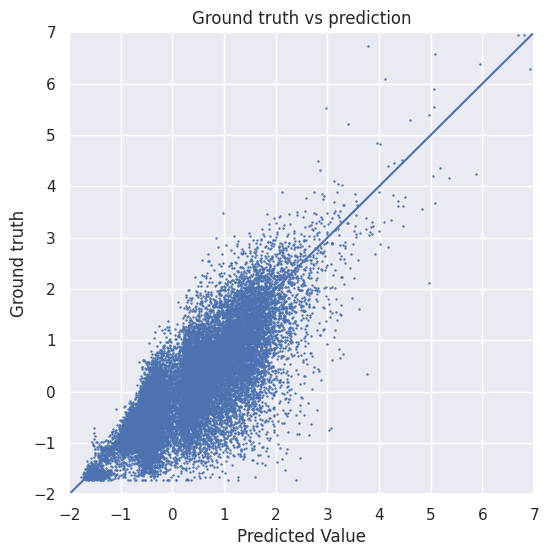

In [98]:
# Plot target and prediction for training data

plot_targets(gin_train_target, gin_train_y_target)

Test Loss for GCN: 0.5918554067611694


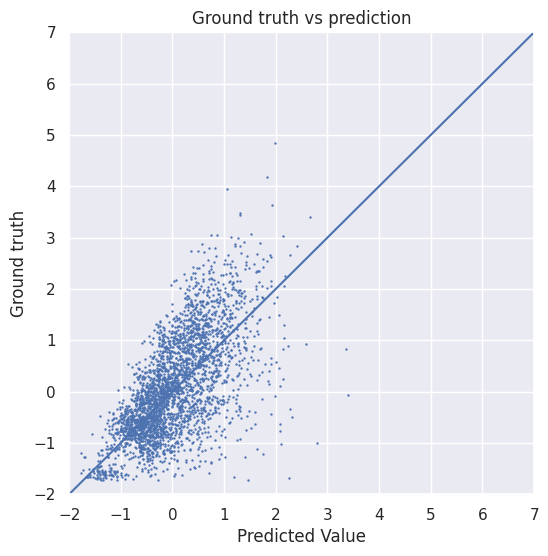

In [100]:
# Calculate test loss from the best GCN model (according to validation loss)

# load our model
model = GCN(dim_h=128)
model.load_state_dict(torch.load("/content/teachopencadd/teachopencadd/talktorials/T035_graph_neural_networks/GCN_best-model-parameters.pt"))

# calculate test loss
gcn_test_loss, gcn_test_target, gcn_test_y = testing(test_loader, model)

print("Test Loss for GCN: " + str(gcn_test_loss.item()))

# plot prediction vs ground truth
plot_targets(gcn_test_target, gcn_test_y)

Test Loss for GIN: 0.3254297375679016


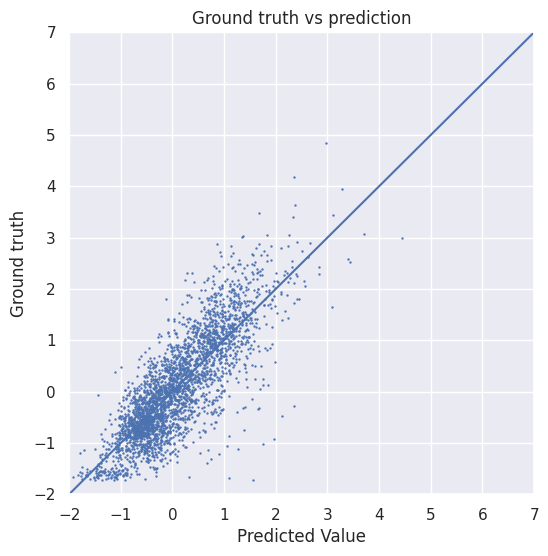

In [101]:
# Calculate test loss from the best GIN model (according to validation loss)

# load our model
model = GIN(dim_h=64)
model.load_state_dict(torch.load("/content/teachopencadd/teachopencadd/talktorials/T035_graph_neural_networks/GIN_best-model-parameters.pt"))

# calculate test loss
gin_test_loss, gin_test_target, gin_test_y = testing(test_loader, model)

print("Test Loss for GIN: " + str(gin_test_loss.item()))

# plot prediction vs ground truth
plot_targets(gin_test_target, gin_test_y)

**Discussion**

In this tutorial we have first presented two different graph neural networks. We applied these two GNNs to a molecular dataset to predict molecular properties. We showed how to train and evaluate a simple GNN using pytorch and pytorch_geometric. This model can be used for any type of graph-level regression and, with small changes (such as the loss function), graph-level classification is also easy.

One disadvantage of GNNs is that the quality of the model is extremely data-dependent, the more of the chemical space is covered in the training set, the better the performance would be on new, unseen data. In addition, training a model can be rather complex, since there are many parameters influencing the model. Model parameters, such as learning rate, batch size and number of hidden dimensions could be more thoroughly evaluated to improve the model. To apply this to real tasks, first, a bigger dataset is needed. When using the whole QM9 dataset and not only a small subset, the performance will increase. In addition, the model parameters can also still be optimized. The model architecture can also still be adapted. These changes could lead to longer runtimes, which is why we have chosen this simplified version for demonstration purposes.